# Automating Price Updates
- **Purpose of the Code**:
    - The code generates a detailed file with information on product price changes.
    - It indicates the warehouse where the modification occurred, the current price, and the previous price.

- **Identifying Price Update Locations**:
    - Identifies all possible combinations of warehouse locations and suppliers.
    - Highlights locations where prices have been updated in the system.

- **Data Processing**:
    - Loads raw data from Excel files (new price files and system data).
    - Cleans data by removing unnecessary characters and accents.
    - Formats columns for data consistency and uniformity.

- **Automatic Price Assignment**:
    - Assigns new prices based on warehouse branches and predefined price maps.
    - Verifies where actual changes have taken place.

- **Combination Generation for Location Updates**:
    - Automatically creates all possible combinations of warehouse locations and their updated prices.
    - Eliminates the need for manual location search and assignment.

- **Rounding and Filtering**:
    - Automatically rounds prices to four decimal places, as required by the company’s system.
    - Applies filters to the final data for easier review.

# STI supplier 

In [4]:
import pandas as pd
import os
from datetime import datetime
import re
import unicodedata

In [5]:
# File paths
BASE_FILE_PATH_STI = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Raw data STI.xlsx'
HUBBLE_DATA_PATH_STI = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Hubble Data STI.xlsx'
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'

In [6]:
# Remove accents
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFD', input_str)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

In [7]:
# Load Excel files
def load_excel_files(base_file_path, hubble_data_path):
    if not os.path.exists(base_file_path):
        raise FileNotFoundError(f"Base file not found: {base_file_path}")
    if not os.path.exists(hubble_data_path):
        raise FileNotFoundError(f"Hubble file not found: {hubble_data_path}")
    return pd.read_excel(base_file_path), pd.read_excel(hubble_data_path)

In [8]:
# Rename columns
def rename_columns(df, source_type):
    df.columns = df.columns.str.strip().str.replace(r'[\n\r]+', ' ', regex=True)
    df.columns = df.columns.map(remove_accents).str.replace(r'\s+', ' ', regex=True)
    columns_rename_map = {
        'Item number': 'Item',
        'DAP Price TAT': 'DAP Price TAT',
        'DAP Price PDC': 'DAP Price PDC',
        'DAP Price NYI': 'DAP Price NYI',
        'DAP Price France': 'DAP Price France'
    }
    df.rename(columns={col: columns_rename_map[col] for col in df.columns if col in columns_rename_map}, inplace=True)

In [9]:
# Keep specific columns
def clean_columns(df):
    return df[['Item', 'DAP Price TAT', 'DAP Price PDC', 'DAP Price NYI', 'DAP Price France']]
# Prepare Hubble data
def prepare_hubble_data(df):
    expected_columns = [
        '2ND ITEM NUMBER', 'DESCRIPTION', 'SUPPLIER NUMBER', 'SUPPLIER DESCRIPTION', 'AMOUNT - UNIT COST',
        'BRANCH PLANT', 'CURRENCY CODE - FROM', 'UNIT OF MEASURE AS INPUT', 'QUANTITY BREAK',
        'DATE - EFFECTIVE', 'DATE - EXPIRED', 'USER ID', 'DATE - UPDATED', 'IM BUYR NO.', 'IM BUYR'
    ]
    df.rename(columns=dict(zip(df.columns, expected_columns)), inplace=True)

    if 'DATE - EXPIRED' not in df.columns:
        df['DATE - EXPIRED'] = pd.NaT
    df[['DATE - EFFECTIVE', 'DATE - EXPIRED']] = df[['DATE - EFFECTIVE', 'DATE - EXPIRED']].apply(pd.to_datetime, errors='coerce')
    df['AMOUNT - UNIT COST'] = df['AMOUNT - UNIT COST'].apply(lambda x: float(re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0]) if re.findall(r"[-+]?\d*\.\d+|\d+", str(x)) else 0)
    return df

In [10]:
# Merge data
def merge_data(base_df, hubble_df):
    base_df['Item'] = base_df['Item'].astype(str).str.upper()
    hubble_df['2ND ITEM NUMBER'] = hubble_df['2ND ITEM NUMBER'].astype(str).str.upper()
    return pd.merge(base_df, hubble_df, left_on='Item', right_on='2ND ITEM NUMBER', how='left')

In [11]:
# Calculate new price
def get_new_price(row, branch_map):
    plant = str(row['BRANCH PLANT'])
    for price_column, plants in branch_map.items():
        if plant in plants and pd.notna(row[price_column]):
            return row[price_column]
    return None

In [12]:
# Add new price column
def add_new_price(df, branch_map):
    df['New Price'] = df.apply(get_new_price, axis=1, branch_map=branch_map)
    df['Not Updated on BPs'] = df.apply(lambda row: row['BRANCH PLANT'] if pd.isna(row['New Price']) else '', axis=1)
    return df

In [13]:
# Branch price mapping for STI
def get_branch_price_map():
    return {
        'DAP Price TAT': ['490810', '490813', '490851'],
        'DAP Price PDC': ['110816', '110858'],
        'DAP Price NYI': ['490815', '490852'],
        'DAP Price France': ['351810', '351650', '351866']
    }

In [14]:
# Handle duplicates
def handle_duplicates(merged_df):
    merged_df['DATE - EFFECTIVE'] = pd.to_datetime(merged_df['DATE - EFFECTIVE'], errors='coerce')
    merged_df = merged_df.sort_values(by=['Item', 'SUPPLIER NUMBER', 'DATE - EFFECTIVE'], ascending=[True, True, False], na_position='last')
    merged_df = merged_df.drop_duplicates(subset=['Item', 'SUPPLIER NUMBER', 'BRANCH PLANT'], keep='first')
    updated_bps_series = merged_df.groupby(['Item', 'SUPPLIER NUMBER'])[['AMOUNT - UNIT COST', 'BRANCH PLANT']].apply(
        lambda group: ', '.join(group.loc[group['AMOUNT - UNIT COST'] != 0, 'BRANCH PLANT'].dropna().astype(str).unique())
    )
    return merged_df, updated_bps_series.reset_index(name='Updated on BPs')

In [15]:
# Split rows
def split_and_expand_rows(grouped_df):
    grouped_df['BRANCH PLANT'] = grouped_df['BRANCH PLANT'].astype(str)
    grouped_df['Updated on BPs'] = grouped_df['Updated on BPs'].astype(str)

    expanded_rows = []
    for _, row in grouped_df.iterrows():
        branch_plants = row['BRANCH PLANT'].split(', ')
        updated_plants = row['Updated on BPs'].split(', ') if row['Updated on BPs'] else []
        for plant in branch_plants:
            temp_row = row.copy()
            temp_row['BRANCH PLANT'] = plant
            temp_row['Updated on BPs'] = plant if plant in updated_plants else ''
            expanded_rows.append(temp_row)
    return pd.DataFrame(expanded_rows)

In [16]:
# Save to Excel and do the formatting
def save_to_excel(final_df, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        workbook = writer.book
        sheet_name = datetime.now().strftime('%d-%m-%Y')
        final_df.to_excel(writer, sheet_name=sheet_name, index=False, header=False, startrow=1)

        worksheet = writer.sheets[sheet_name]
        header_format = workbook.add_format({'bold': True, 'align': 'center', 'border': 1})
        old_price_header_format = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#FFCCCC', 'border': 1})
        new_price_header_format = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#CCFFCC', 'border': 1})
        number_format = workbook.add_format({'num_format': '0.0000', 'align': 'center', 'border': 1})

        for col_num, value in enumerate(final_df.columns):
            if value == 'Old Price':
                worksheet.write(0, col_num, value, old_price_header_format)
                worksheet.set_column(col_num, col_num, 15, number_format)
            elif value == 'New Price':
                worksheet.write(0, col_num, value, new_price_header_format)
                worksheet.set_column(col_num, col_num, 15, number_format)
            else:
                worksheet.write(0, col_num, value, header_format)
                max_len = max(final_df[value].astype(str).map(len).max(), len(value)) + 2
                worksheet.set_column(col_num, col_num, max_len, workbook.add_format({'align': 'center', 'border': 1}))

        for row_num in range(1, len(final_df) + 1):
            for col_num, value in enumerate(final_df.columns):
                cell_value = final_df.iloc[row_num - 1, col_num]
                if value in ['Old Price', 'New Price']:
                    worksheet.write_number(row_num, col_num, cell_value, number_format)
                else:
                    worksheet.write(row_num, col_num, cell_value, workbook.add_format({'align': 'center', 'border': 1}))

        worksheet.autofilter(0, 0, len(final_df), len(final_df.columns) - 1)

In [17]:
# Final execution
try:
    base_file_df, hubble_data_df = load_excel_files(BASE_FILE_PATH_STI, HUBBLE_DATA_PATH_STI)
    rename_columns(base_file_df, 'STI')
    base_file_df = clean_columns(base_file_df)
    hubble_data_df = prepare_hubble_data(hubble_data_df)
    merged_df = merge_data(base_file_df, hubble_data_df)

    branch_price_map = get_branch_price_map()
    merged_df = add_new_price(merged_df, branch_price_map)
    merged_df, updated_bps_df = handle_duplicates(merged_df)

    grouped_df = merged_df.merge(updated_bps_df, on=['Item', 'SUPPLIER NUMBER'], how='left').fillna('')
    expanded_df = split_and_expand_rows(grouped_df)

    expanded_df = expanded_df.rename(columns={
        'Item': 'Item Number',
        'AMOUNT - UNIT COST': 'Old Price',
        'CURRENCY CODE - FROM': 'Currency',
        'UNIT OF MEASURE AS INPUT': 'UoM'
    })

    expanded_df['Old Price'] = pd.to_numeric(expanded_df['Old Price'], errors='coerce').fillna(0)
    expanded_df['New Price'] = pd.to_numeric(expanded_df['New Price'], errors='coerce').fillna(0)

    final_df = expanded_df[['SUPPLIER DESCRIPTION', 'SUPPLIER NUMBER', 'Item Number', 'BRANCH PLANT',
                            'UoM', 'Updated on BPs', 'New Price', 'Old Price', 'Currency']]

    output_path = os.path.join(OUTPUT_DIRECTORY, f'Updated_NewData_STI_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.xlsx')
    save_to_excel(final_df, output_path)
    print(f"Data has been merged and saved to '{output_path}'")

except Exception as e:
    print(f"An error occurred: {e}")

Data has been merged and saved to 'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data\Updated_NewData_STI_2024-11-02_20-32-15.xlsx'


# API Template for STI
The code automates data preparation and insertion into a pre-existing Excel file (API Template) with detailed price change information, allowing easy data entry based on a specific effective date and main reasons for the price updates.

In [16]:
import pandas as pd
import os
from datetime import datetime

In [17]:
# Column mapping
column_mapping = {
    'SUPPLIER DESCRIPTION': 'Supplier Name',
    'SUPPLIER NUMBER': 'Supplier Number',
    'Item Number': 'Item Number',
    'New Price': 'New price',
    'Currency': 'Item Price Currency',
    'UoM': 'Unit of measure',
    'BRANCH PLANT': 'Branch Plant'
}

In [18]:
# Ask for the Effective Date
effective_date_str = input("Please enter the Effective date (DD.MM.YYYY): ")
try:
    if '.' in effective_date_str:
        effective_date = datetime.strptime(effective_date_str, "%d.%m.%Y")
except ValueError:
    raise ValueError("Invalid date format. Please use DD.MM.YYYY format")

In [19]:
# Ask for Main Reasons and weights
main_reasons = []
weights = []
for i in range(1, 4):
    reason = input(f"Enter Main Reason {i} (or press Enter to skip): ").strip()
    if reason:
        main_reasons.append(reason)
        if len(main_reasons) > 1:
            weight_str = input(f"Enter Weight (%) for Main Reason {i} (e.g., 100): ").strip()
            try:
                weight = float(weight_str)
            except ValueError:
                raise ValueError("Weight should be a number.")
            weights.append(weight)
        else:
            # Set weight to 100% automatically if this is the only reason
            weights.append(100.0)
    else:
        break
if len(main_reasons) > 1 and sum(weights) != 100:
    raise ValueError("The sum of weights for multiple reasons must equal 100%")


In [21]:
# Load the data and mapping
folder_path = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'
files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
newest_file = max([os.path.join(folder_path, f) for f in files], key=os.path.getctime)
data = pd.read_excel(newest_file)
mapped_data = pd.DataFrame()
for src_col, dest_col in column_mapping.items():
    if src_col in data.columns:
        mapped_data[dest_col] = data[src_col]
    else:
        mapped_data[dest_col] = ''
for dest_col in column_mapping.values():
    if dest_col not in mapped_data.columns:
        mapped_data[dest_col] = ''
for i, reason in enumerate(main_reasons, 1):
    mapped_data[f"Main Reason {i}"] = reason
    mapped_data[f"Weight (%) Main Reason {i}"] = weights[i-1]

In [22]:
# Load the data
destination_path = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\API Template\API Template.xlsm'
wb = openpyxl.load_workbook(destination_path, keep_vba=True)
sheet = wb.active
header_row = 3
header_cells = list(sheet.iter_rows(min_row=header_row, max_row=header_row, values_only=True))[0]
column_indexes = {col_name: idx + 1 for idx, col_name in enumerate(header_cells) if col_name in mapped_data.columns}
for reason_col in mapped_data.columns:
    if reason_col not in column_indexes and reason_col in mapped_data.columns:
        column_indexes[reason_col] = header_cells.index(reason_col) + 1 if reason_col in header_cells else None
start_row = 4
thin_border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))

for index, row in mapped_data.iterrows():
    cell = sheet.cell(row=start_row + index, column=1, value=effective_date.strftime("%d.%m.%Y"))
    cell.border = thin_border
    for col_name, value in row.items():
        if col_name in column_indexes and column_indexes[col_name] is not None:
            col_index = column_indexes[col_name]
            cell = sheet.cell(row=start_row + index, column=col_index, value=value)
            cell.border = thin_border

In [23]:
# Save the workbook
wb.save(destination_path)
print(f"Data successfully copied to {destination_path}")

Data successfully copied to C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\API Template\API Template.xlsm


# VG Supplier 

In [9]:
import pandas as pd
import os
from datetime import datetime
import re
import unicodedata

In [10]:
# Source
BASE_FILE_PATH = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Raw data VG.xlsx'
HUBBLE_DATA_PATH = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Hubble Data VG.xlsx'
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'

In [11]:
# Remove Accents
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFD', input_str)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

In [ ]:
# Load Excel
def load_excel_files(base_file_path, hubble_data_path):
    if not os.path.exists(base_file_path):
        raise FileNotFoundError(f"Base file not found: {base_file_path}")
    if not os.path.exists(hubble_data_path):
        raise FileNotFoundError(f"Hubble file not found: {hubble_data_path}")
    base_file_df = pd.read_excel(base_file_path)
    hubble_data_df = pd.read_excel(hubble_data_path)
    return base_file_df, hubble_data_df
def rename_base_file_columns(base_file_df):
    base_file_df.columns = base_file_df.columns.str.strip()
    base_file_df.columns = base_file_df.columns.str.replace(r'[\n\r]+', ' ', regex=True)
    base_file_df.columns = base_file_df.columns.map(remove_accents)
    base_file_df.columns = base_file_df.columns.str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    columns_rename_map = {
        'Item number': 'Item',
        'DAP TAT + PDC': 'DAP TAT + PDC',
        'DAP NYI': 'DAP NYI',
        'DAP Denmark': 'DAP Denmark',
        'FCA Komarom (for CAR)': 'FCA Komarom (for CAR)'
    }
    columns_to_rename = {col: columns_rename_map[col] for col in base_file_df.columns if col in columns_rename_map}
    base_file_df.rename(columns=columns_to_rename, inplace=True)
def clean_base_file_columns(base_file_df):
    columns_to_keep = ['Item', 'DAP TAT + PDC', 'DAP NYI', 'DAP Denmark', 'FCA Komarom (for CAR)']
    return base_file_df.loc[:, base_file_df.columns.isin(columns_to_keep)]

In [ ]:
# Hubble Data
def prepare_hubble_data(hubble_data_df):
    actual_columns = hubble_data_df.columns.tolist()
    expected_columns = [
        '2ND ITEM NUMBER', 'DESCRIPTION', 'SUPPLIER NUMBER', 'SUPPLIER DESCRIPTION', 'AMOUNT - UNIT COST',
        'BRANCH PLANT', 'CURRENCY CODE - FROM', 'UNIT OF MEASURE AS INPUT', 'QUANTITY BREAK',
        'DATE - EFFECTIVE', 'DATE - EXPIRED', 'USER ID', 'DATE - UPDATED', 'IM BUYR NO.', 'IM BUYR'
    ]
    columns_mapping = dict(zip(actual_columns, expected_columns))
    hubble_data_df.rename(columns=columns_mapping, inplace=True)

    if 'DATE - EXPIRED' not in hubble_data_df.columns:
        hubble_data_df['DATE - EXPIRED'] = pd.NaT
    for date_col in ['DATE - EFFECTIVE', 'DATE - EXPIRED']:
        hubble_data_df[date_col] = pd.to_datetime(hubble_data_df[date_col], errors='coerce')

    hubble_data_df['AMOUNT - UNIT COST'] = hubble_data_df['AMOUNT - UNIT COST'].apply(
        lambda x: float(re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0]) if re.findall(r"[-+]?\d*\.\d+|\d+", str(x)) else 0
    )
    return hubble_data_df
def merge_data(base_file_df, hubble_data_df):
    base_file_df['Item'] = base_file_df['Item'].astype(str).str.upper()
    hubble_data_df['2ND ITEM NUMBER'] = hubble_data_df['2ND ITEM NUMBER'].astype(str).str.upper()
    return pd.merge(base_file_df, hubble_data_df, left_on='Item', right_on='2ND ITEM NUMBER', how='left')
def get_new_price(row, branch_price_map):
    branch_plant = str(row['BRANCH PLANT'])
    for price_column, plants in branch_price_map.items():
        if price_column in row and branch_plant in plants:
            if pd.notna(row[price_column]):
                return row[price_column]
    return None
def add_new_price_column(merged_df, branch_price_map):
    merged_df['New Price'] = merged_df.apply(get_new_price, axis=1, branch_price_map=branch_price_map)
    return merged_df

In [ ]:
# Duplicates
def handle_duplicates(merged_df):
    if 'DATE - EFFECTIVE' not in merged_df.columns:
        merged_df['DATE - EFFECTIVE'] = pd.NaT
    merged_df['DATE - EFFECTIVE'] = pd.to_datetime(merged_df['DATE - EFFECTIVE'], errors='coerce')
    merged_df = merged_df.sort_values(by=['Item', 'SUPPLIER NUMBER', 'DATE - EFFECTIVE'], ascending=[True, True, False], na_position='last')
    merged_df = merged_df.drop_duplicates(subset=['Item', 'SUPPLIER NUMBER', 'BRANCH PLANT'], keep='first')
    updated_bps_series = merged_df.groupby(['Item', 'SUPPLIER NUMBER'])[['AMOUNT - UNIT COST', 'BRANCH PLANT']].apply(
        lambda group: ', '.join(group.loc[group['AMOUNT - UNIT COST'] != 0, 'BRANCH PLANT'].dropna().astype(str).unique())
    )
    return merged_df, updated_bps_series.reset_index(name='Updated on BPs')
def group_data(merged_df, updated_bps_df):
    grouped_df = merged_df.merge(updated_bps_df, on=['Item', 'SUPPLIER NUMBER'], how='left')
    grouped_df['Updated on BPs'] = grouped_df['Updated on BPs'].fillna('')
    grouped_df['BRANCH PLANT'] = grouped_df['BRANCH PLANT'].apply(lambda x: ', '.join([str(int(float(plant))) if plant.endswith('.0') else plant for plant in str(x).split(', ')]))
    grouped_df['Updated on BPs'] = grouped_df['Updated on BPs'].apply(lambda x: ', '.join([str(int(float(plant))) if plant.endswith('.0') else plant for plant in str(x).split(', ')]))
    return grouped_df

In [15]:
# Split Rows
def split_and_expand_rows(grouped_df):
    expanded_rows = []
    for _, row in grouped_df.iterrows():
        branch_plants = row['BRANCH PLANT'].split(', ')
        updated_plants = row['Updated on BPs'].split(', ') if row['Updated on BPs'] else []
        for plant in branch_plants:
            temp_row = row.copy()
            temp_row['BRANCH PLANT'] = plant
            temp_row['Updated on BPs'] = plant if plant in updated_plants else ''
            expanded_rows.append(temp_row)
    return pd.DataFrame(expanded_rows)
def save_branch_plants_separately(merged_df):
    branch_plant_df = merged_df[['Item', 'SUPPLIER NUMBER', 'BRANCH PLANT']].copy()
    branch_plant_df = branch_plant_df.drop_duplicates()
    output_path = os.path.join(OUTPUT_DIRECTORY, f'Branch_Plants_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.xlsx')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

In [16]:
# Save to Excel
def save_to_excel(final_df, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        workbook = writer.book
        sheet_name = datetime.now().strftime('%d-%m-%Y')
        final_df.to_excel(writer, sheet_name=sheet_name, index=False, header=False, startrow=1)
        worksheet = writer.sheets[sheet_name]
        header_format = workbook.add_format({'bold': True, 'align': 'center', 'border': 1})
        old_price_header_format = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#FFCCCC', 'border': 1})
        new_price_header_format = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#CCFFCC', 'border': 1})
        number_format = workbook.add_format({'num_format': '0.0000', 'align': 'center', 'border': 1})
        for col_num, value in enumerate(final_df.columns):
            if value == 'Old Price':
                worksheet.write(0, col_num, value, old_price_header_format)
                worksheet.set_column(col_num, col_num, 15, number_format)
            elif value == 'New Price':
                worksheet.write(0, col_num, value, new_price_header_format)
                worksheet.set_column(col_num, col_num, 15, number_format)
            else:
                worksheet.write(0, col_num, value, header_format)
                max_len = max(final_df[value].astype(str).map(len).max(), len(value)) + 2
                worksheet.set_column(col_num, col_num, max_len, workbook.add_format({'align': 'center', 'border': 1}))
        for row_num in range(1, len(final_df) + 1):
            for col_num, value in enumerate(final_df.columns):
                cell_value = final_df.iloc[row_num - 1, col_num]
                if value in ['Old Price', 'New Price']:
                    worksheet.write_number(row_num, col_num, cell_value, number_format)
                else:
                    worksheet.write(row_num, col_num, cell_value, workbook.add_format({'align': 'center', 'border': 1}))

        worksheet.autofilter(0, 0, len(final_df), len(final_df.columns) - 1)
try:
    base_file_df, hubble_data_df = load_excel_files(BASE_FILE_PATH, HUBBLE_DATA_PATH)
    rename_base_file_columns(base_file_df)  # Call this before cleaning columns
    base_file_df = clean_base_file_columns(base_file_df)
    hubble_data_df = prepare_hubble_data(hubble_data_df)
    merged_df = merge_data(base_file_df, hubble_data_df)
    branch_price_map = {
        'DAP TAT + PDC': ['110816', '110858', '490810', '490851', '490813'],
        'DAP NYI': ['490815', '490852'],
        'DAP Denmark': ['110818', '110813', '110852', '110817', '110857'],
        'FCA Komarom (for CAR)': ['790810', '790851']
    }
    merged_df = add_new_price_column(merged_df, branch_price_map)
    merged_df, updated_bps_df = handle_duplicates(merged_df)
    grouped_df = group_data(merged_df, updated_bps_df)
    final_df = split_and_expand_rows(grouped_df)
    final_df = final_df.rename(columns={
        'Item': 'Item Number',
        'AMOUNT - UNIT COST': 'Old Price',
        'CURRENCY CODE - FROM': 'Currency',
        'UNIT OF MEASURE AS INPUT': 'UoM'
    })
    final_df['Old Price'] = pd.to_numeric(final_df['Old Price'], errors='coerce').fillna(0)
    final_df['New Price'] = pd.to_numeric(final_df['New Price'], errors='coerce').fillna(0)
    final_df = final_df[['SUPPLIER DESCRIPTION', 'SUPPLIER NUMBER', 'Item Number', 'BRANCH PLANT',
                         'UoM', 'Updated on BPs', 'New Price', 'Old Price', 'Currency']]
    final_df = final_df.replace([float('inf'), float('-inf')], float('nan')).fillna(0)
    save_branch_plants_separately(merged_df)
    output_path = os.path.join(OUTPUT_DIRECTORY, f'Updated_NewData_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.xlsx')
    save_to_excel(final_df, output_path)
    print(f"Data has been merged and saved to '{output_path}'")
except Exception as e:
    print(f"An error occurred: {e}")

Data has been merged and saved to 'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data\Updated_NewData_2024-11-02_21-11-33.xlsx'


# API Template for VG

In [17]:
import pandas as pd
import openpyxl
import os
from datetime import datetime
import re
import unicodedata
import warnings
from openpyxl.styles import Border, Side

In [18]:
# Column mapping
column_mapping = {
    'SUPPLIER DESCRIPTION': 'Supplier Name',
    'SUPPLIER NUMBER': 'Supplier Number',
    'Item Number': 'Item Number',
    'New Price': 'New price',
    'Currency': 'Item Price Currency',
    'UoM': 'Unit of measure',
    'BRANCH PLANT': 'Branch Plant'
}

In [19]:
# Ask for the Effective Date
effective_date_str = input("Please enter the Effective date (DDMMYYYY or DD.MM.YYYY): ")
try:
    if '.' in effective_date_str:
        effective_date = datetime.strptime(effective_date_str, "%d.%m.%Y")
    else:
        effective_date = datetime.strptime(effective_date_str, "%d%m%Y")
except ValueError:
    raise ValueError("Invalid date format. Please use DDMMYYYY or DD.MM.YYYY.")

In [20]:
# Load
folder_path = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'
files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
newest_file = max([os.path.join(folder_path, f) for f in files], key=os.path.getctime)
data = pd.read_excel(newest_file)

In [21]:
# Mapping columns
mapped_data = pd.DataFrame()
for src_col, dest_col in column_mapping.items():
    if src_col in data.columns:
        mapped_data[dest_col] = data[src_col]
    else:
        mapped_data[dest_col] = ''
for dest_col in column_mapping.values():
    if dest_col not in mapped_data.columns:
        mapped_data[dest_col] = ''

In [22]:
# Load
destination_path = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\API Template\API Template.xlsm'
wb = openpyxl.load_workbook(destination_path, keep_vba=True)
sheet = wb.active

In [23]:
# Column indexes
header_row = 3
header_cells = list(sheet.iter_rows(min_row=header_row, max_row=header_row, values_only=True))[0]
column_indexes = {col_name: idx + 1 for idx, col_name in enumerate(header_cells) if col_name in mapped_data.columns}
start_row = 4
thin_border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))
for index, row in mapped_data.iterrows():
    cell = sheet.cell(row=start_row + index, column=1, value=effective_date.strftime("%d.%m.%Y"))
    cell.border = thin_border
    for col_name, value in row.items():
        if col_name in column_indexes:
            col_index = column_indexes[col_name]
            cell = sheet.cell(row=start_row + index, column=col_index, value=value)
            cell.border = thin_border

In [24]:
# Save the workbook
wb.save(destination_path)
print(f"Data successfully copied to {destination_path}")

Data successfully copied to C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\API Template\API Template.xlsm


# Cost method to be assigned in the system

In [25]:
import pandas as pd
import warnings
import random
from openpyxl import load_workbook
from openpyxl.styles import Border, Side

In [26]:
# Paths
item_branch_path = r"C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Item Branch.xlsx"
manual_upload_path = r"C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Manual Upload Template.xlsm"
output_path = r"C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\620\620.xlsx"

In [27]:
# Read, extract, rename and standarize 
item_branch_df = pd.read_excel(item_branch_path)
manual_upload_df = pd.read_excel(manual_upload_path)
item_branch_df = item_branch_df[['SUPPLIER NUMBER', 'ITEM NUMBER', 'BRANCH PLANT']]
manual_upload_df = manual_upload_df[['Supplier Number', 'Item Number', 'Branch Plant']]
item_branch_df.columns = ['Supplier Number', 'Item Number', 'Branch Plant']
key_cols = ['Supplier Number', 'Item Number', 'Branch Plant']
for col in key_cols:
    item_branch_df[col] = item_branch_df[col].astype(str).str.strip().str.upper()
    manual_upload_df[col] = manual_upload_df[col].astype(str).str.strip().str.upper()
manual_upload_df['OriginalOrder'] = manual_upload_df.index
valid_combinations = item_branch_df.drop_duplicates(subset=key_cols)


c:\Users\plmala\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [29]:
# Merge
merged_df = pd.merge(
    manual_upload_df,
    valid_combinations,
    on=key_cols,
    how='left',
    indicator=True,
    sort=False
)
merged_df['620'] = ''

In [30]:
# Define the prefixes and assign 620 
branch_prefixes = ['790', '620', '110', '490', '351', '711']
def set_620_flag_based_on_validation(df):
    grouped = df.groupby(['Supplier Number', 'Item Number'])
    for (supplier_number, item_number), group in grouped:
        for prefix in branch_prefixes:
            prefix_matches = group[
                group['Branch Plant'].str.startswith(prefix) &
                (group['_merge'] == 'both')
            ]
            if len(prefix_matches) >= 1:
                selected_index = random.choice(prefix_matches.index)
                df.loc[selected_index, '620'] = '620'
                break
    return df

In [31]:
# Apply the function
merged_df = set_620_flag_based_on_validation(merged_df)

# Sort
merged_df = merged_df.sort_values('OriginalOrder')

# Drop
merged_df.drop(columns=['_merge', 'OriginalOrder'], inplace=True)

# Final column order
final_columns = ['Supplier Number', 'Item Number', 'Branch Plant', '620']
merged_df = merged_df[final_columns]

In [32]:
# Save the output file while preserving the order of manual_upload_df
merged_df.to_excel(output_path, index=False)
wb = load_workbook(output_path)
ws = wb.active
thin_border = Border(
    left=Side(style="thin"),
    right=Side(style="thin"),
    top=Side(style="thin"),
    bottom=Side(style="thin")
)
for row in ws.iter_rows():
    for cell in row:
        cell.border = thin_border
wb.save(output_path)

print(f"File saved with borders at {output_path}")

File saved with borders at C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\620\620.xlsx


# Visualizations

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

In [34]:
# Paths
BASE_FILE_PATH = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Raw data VG.xlsx'
HUBBLE_DATA_PATH = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\Hubble Data.xlsx'
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'

In [ ]:
# Load
list_of_files = [os.path.join(OUTPUT_DIRECTORY, f) for f in os.listdir(OUTPUT_DIRECTORY) if f.endswith('.xlsx')]
if list_of_files:
    latest_file = max(list_of_files, key=os.path.getctime)
    output_path = latest_file
else:
    output_path = None
if output_path:
    try:
        final_df = pd.read_excel(output_path)
    except FileNotFoundError:
        print(f"The file at '{output_path}' was not found. Please check the file path.")
else:
    print("No files found")

In [44]:
def visualize_branch_plant_price_distribution(df):
    if 'BRANCH PLANT' in df.columns and 'New Price' in df.columns:
        df_filtered = df[['BRANCH PLANT', 'New Price']].dropna(subset=['New Price'])
        df_filtered = df_filtered[df_filtered['New Price'] > 0]
        if not df_filtered.empty:
            df_grouped = df_filtered.groupby('BRANCH PLANT')['New Price'].mean().reset_index()
            df_grouped['BRANCH PLANT'] = df_grouped['BRANCH PLANT'].astype(str)
            df_grouped = df_grouped.sort_values(by='New Price', ascending=False)
            plt.figure(figsize=(12, 7))
            plt.bar(df_grouped['BRANCH PLANT'], df_grouped['New Price'], color='purple', alpha=0.7)
            plt.xlabel('Branch Plant')
            plt.ylabel('Average New Price')
            plt.title('Branch Plant Price Distribution')
            plt.xticks(rotation=90, ha='right')  #
            plt.tight_layout()
            plt.show()
        else:
            print("No valid data")

The following chart presents a breakdown of statistics on the most common locations where products are delivered and the frequency of price updates when new prices are provided by the supplier. The X-axis represents branches (BRANCH PLANT – locations where production takes place), while the Y-axis shows the number of price updates for each branch. This visualization gives a clear picture of which branches had the most price updates, which can be useful for analyzing which locations experience frequent price changes, potentially indicating dynamic shifts in demand or costs.

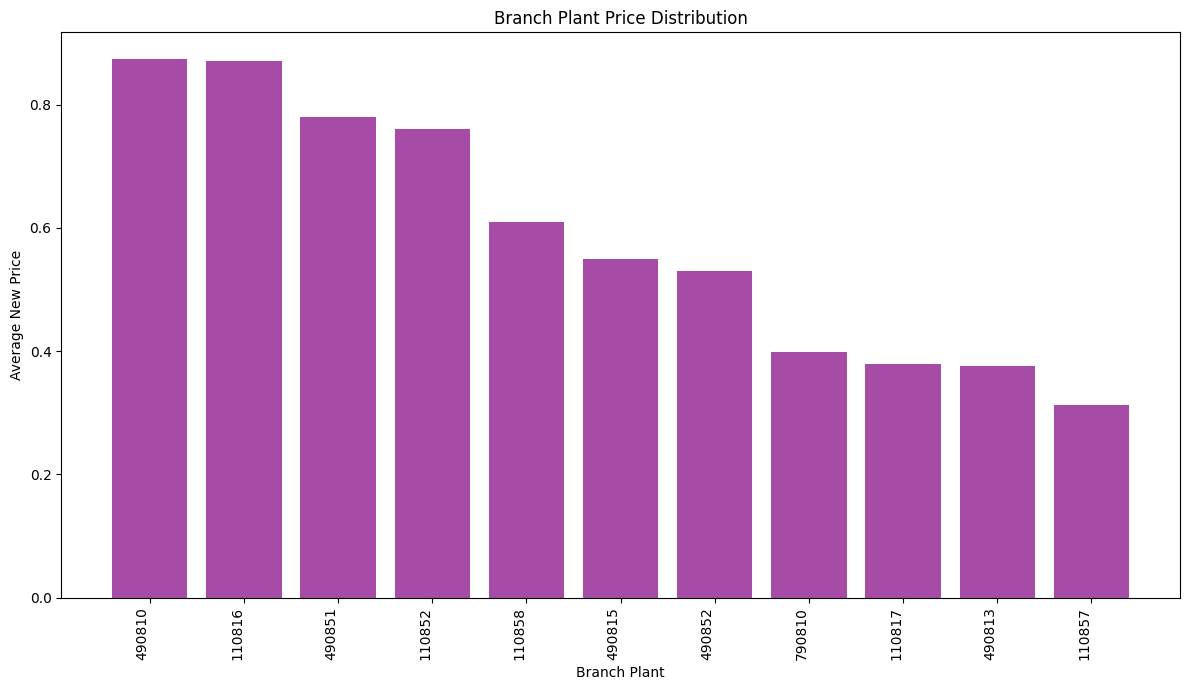

In [45]:
if 'final_df' in locals() and isinstance(final_df, pd.DataFrame):
    visualize_branch_plant_price_distribution(final_df)
else:
    print("The variable 'final_df' is not defined or not a DataFrame.")

The data generated by the Python code also enables the identification of products with the largest percentage price differences compared to previous updates. Such significant differences may indicate dynamic market changes, increased supply or production costs, and may help detect potential errors from manual data entry in the system. Analyzing these deviations allows for quick responses and verification of possible discrepancies. 

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

In [ ]:
# Define the function
def get_latest_file(directory, pattern='*.xlsx'):
    files = glob.glob(os.path.join(directory, pattern))
    if not files:
        raise FileNotFoundError(f"No files found in {directory} matching pattern {pattern}")
    latest_file = max(files, key=os.path.getctime)
    return latest_file

In [79]:
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'

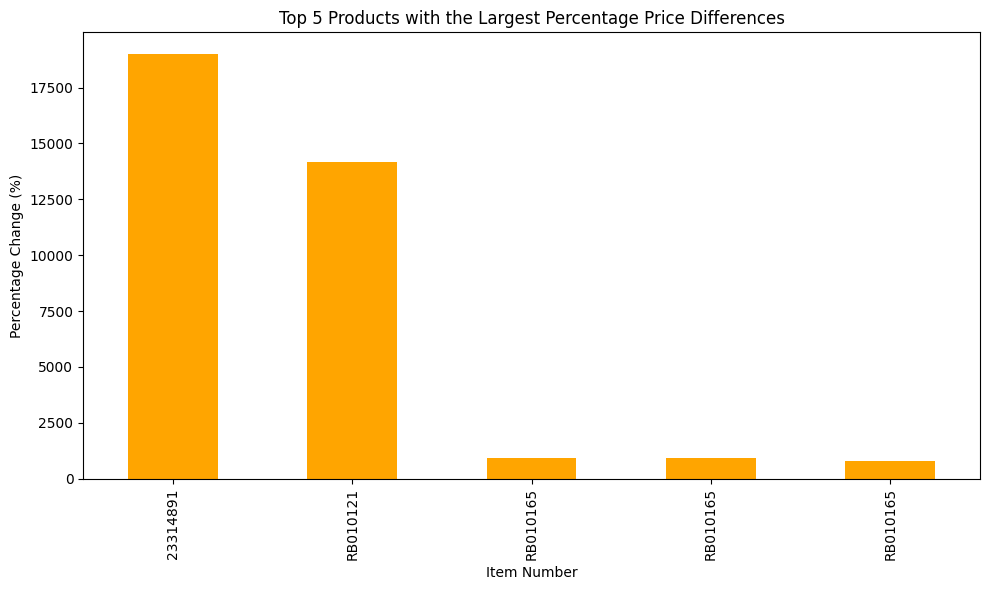

In [82]:
try:
    latest_file = get_latest_file(OUTPUT_DIRECTORY, pattern='Updated_NewData_*.xlsx')
    viz_df = pd.read_excel(latest_file)
    viz_df['Old Price'] = pd.to_numeric(viz_df['Old Price'], errors='coerce').fillna(0)
    viz_df['New Price'] = pd.to_numeric(viz_df['New Price'], errors='coerce').fillna(0)
    viz_df['Price Difference'] = viz_df['New Price'] - viz_df['Old Price']
    viz_df['Percentage Change'] = np.where(
        viz_df['Old Price'] != 0,
        (viz_df['Price Difference'] / viz_df['Old Price']) * 100,
        np.nan
    )
    top5_pct_diff = viz_df[viz_df['Old Price'] != 0].reindex(
        viz_df['Percentage Change'].abs().sort_values(ascending=False).index
    ).head(5)
    plt.figure(figsize=(10, 6))
    top5_pct_diff.set_index('Item Number')['Percentage Change'].plot(kind='bar', color='orange')
    plt.title('Top 5 Products with the Largest Percentage Price Differences')
    plt.xlabel('Item Number')
    plt.ylabel('Percentage Change (%)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

Additionally, a more detailed chart has been created to illustrate the above price situation. This chart is based on an in-depth data analysis, providing a clearer view of price changes. Data is pulled from the latest file in the output directory, then processed to identify products with the largest price differences. For each of the five products with the highest price differences, the absolute and percentage changes are calculated.

In [83]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Function
def get_latest_file(directory, pattern='*.xlsx'):
    files = glob.glob(os.path.join(directory, pattern))
    if not files:
        raise FileNotFoundError(f"No files found in {directory} matching pattern {pattern}")
    latest_file = max(files, key=os.path.getctime)
    return latest_file

In [85]:
# Set the directory
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'

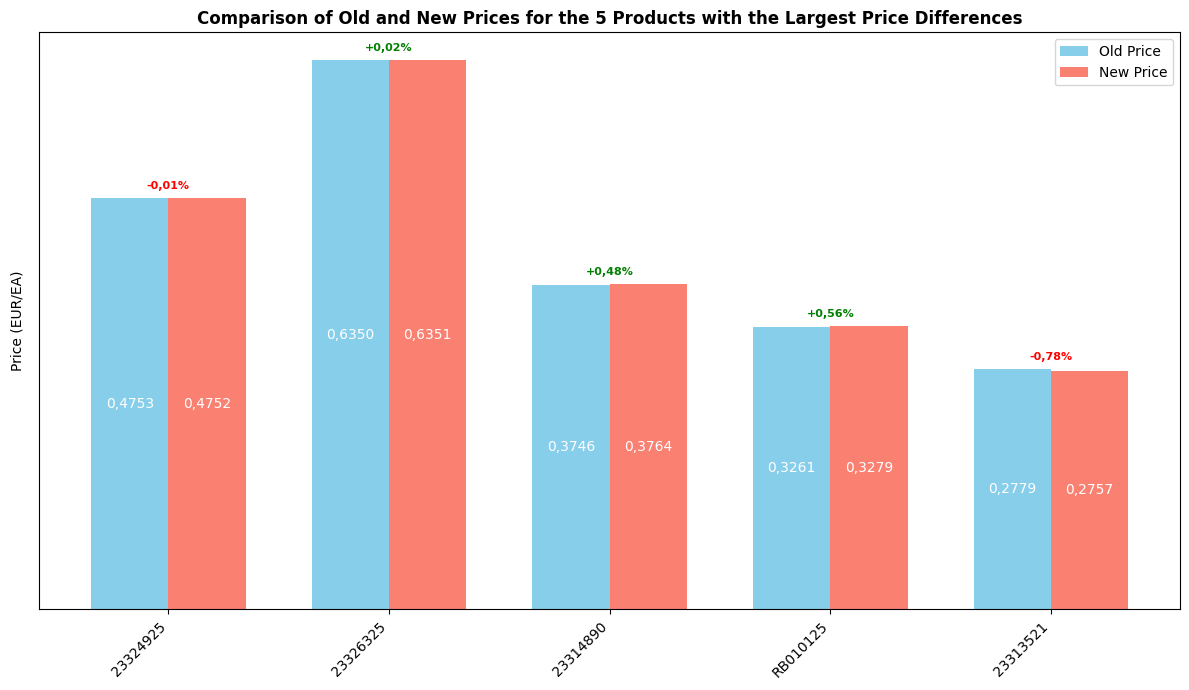

In [86]:
try:
    latest_file = get_latest_file(OUTPUT_DIRECTORY, pattern='Updated_NewData_*.xlsx')
    viz_df = pd.read_excel(latest_file)
    viz_df['Old Price'] = pd.to_numeric(viz_df['Old Price'], errors='coerce').fillna(0)
    viz_df['New Price'] = pd.to_numeric(viz_df['New Price'], errors='coerce').fillna(0)
    viz_df['Price Difference'] = viz_df['New Price'] - viz_df['Old Price']
    viz_df['Percentage Change'] = np.where(
        viz_df['Old Price'] != 0,
        (viz_df['Price Difference'] / viz_df['Old Price']) * 100,
        np.nan
    )
    viz_df_nonzero = viz_df[viz_df['Price Difference'] != 0].copy()
    top5_smallest_diff = viz_df_nonzero.reindex(
        viz_df_nonzero['Price Difference'].abs().sort_values(ascending=True).index
    ).head(5)
    items = top5_smallest_diff['Item Number']
    old_prices = top5_smallest_diff['Old Price']
    new_prices = top5_smallest_diff['New Price']
    percentage_changes = top5_smallest_diff['Percentage Change']
    currencies = top5_smallest_diff['Currency']
    uoms = top5_smallest_diff['UoM']
    x = np.arange(len(items))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, old_prices, width, label='Old Price', color='skyblue')
    rects2 = ax.bar(x + width/2, new_prices, width, label='New Price', color='salmon')
    for rect in rects1:
        height = rect.get_height()
        formatted_price = f'{height:.4f}'.replace('.', ',')
        ax.annotate(formatted_price,
                    xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                    xytext=(0, 0),
                    textcoords='offset points',
                    ha='center', va='center', fontsize=10, color='white')
    for rect in rects2:
        height = rect.get_height()
        formatted_price = f'{height:.4f}'.replace('.', ',')
        ax.annotate(formatted_price,
                    xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                    xytext=(0, 0),
                    textcoords='offset points',
                    ha='center', va='center', fontsize=10, color='white')
    for i in range(len(items)):
        bar_height = max(old_prices.iloc[i], new_prices.iloc[i])
        bar_x = x[i]
        percentage = percentage_changes.iloc[i]
        if not np.isnan(percentage):
            formatted_percentage = f'{percentage:+.2f}%'.replace('.', ',')
            color = 'green' if percentage > 0 else 'red'
            ax.annotate(formatted_percentage,
                        xy=(bar_x, bar_height),
                        xytext=(0, 5),
                        textcoords='offset points',
                        ha='center', va='bottom', fontsize=8, fontweight='bold', color=color)
    y_label_currency = currencies.iloc[0] if currencies.nunique() == 1 else ''
    y_label_uom = uoms.iloc[0] if uoms.nunique() == 1 else ''
    ax.set_ylabel(f'Price ({y_label_currency}/{y_label_uom})' if y_label_currency and y_label_uom else 'Price')
    ax.set_title('Comparison of Old and New Prices for the 5 Products with the Largest Price Differences', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(items, rotation=45, ha='right')
    ax.legend()
    ax.yaxis.set_ticks_position('none')
    ax.set_yticklabels([])
    ax.grid(False)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

The extensive amount of manual work previously required for updating prices manually becomes especially clear in the last chart. This chart displays both the total number of unique products for which prices were changed and the number of operations needed to update these products across various warehouse locations or suppliers. It’s evident that updating the price for a single product often requires multiple operations, underscoring the critical role of automation in managing complex processes.

Each price change for a single product can involve multiple warehouse locations, different suppliers, currencies, or units of measure. Without automation, manually implementing these changes would not only demand a significant amount of work but also carry a high risk of errors. This is why automation has become an essential part of modern price management processes, forming the foundation of a more flexible management model.

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [88]:
# Load the final DF
OUTPUT_DIRECTORY = r'C:\Users\plmala\OneDrive - Coloplast A S\Desktop\Python\PPM\Price Updates (Python)\HUVIDE\Project\New data'
file_list = [os.path.join(OUTPUT_DIRECTORY, f) for f in os.listdir(OUTPUT_DIRECTORY) if f.endswith('.xlsx')]
if file_list:
    latest_file = max(file_list, key=os.path.getctime)
    final_df = pd.read_excel(latest_file)

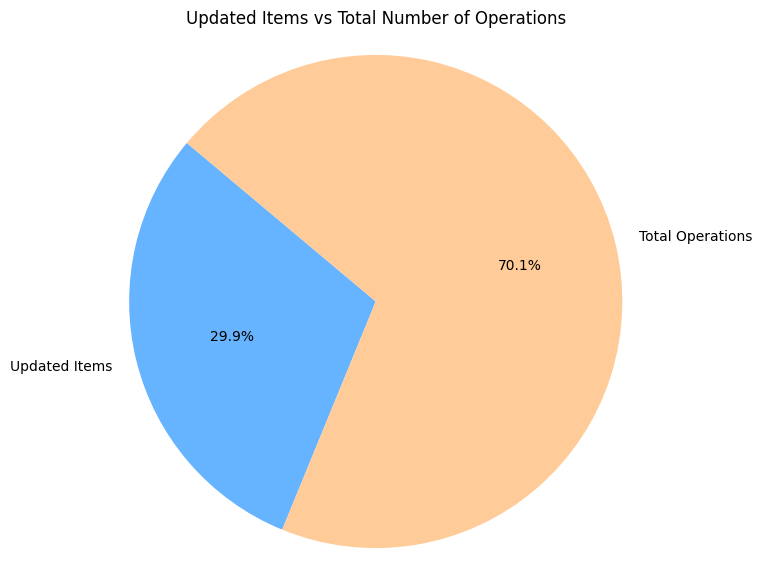

In [89]:
required_columns = ['Item Number', 'BRANCH PLANT', 'SUPPLIER DESCRIPTION']
missing_columns = [col for col in required_columns if col not in final_df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    filtered_df = final_df[['Item Number', 'BRANCH PLANT', 'SUPPLIER DESCRIPTION']].dropna()
    number_of_updated_items = filtered_df['Item Number'].nunique()
    number_of_operations = filtered_df.shape[0]
    labels = ['Updated Items', 'Total Operations']
    sizes = [number_of_updated_items, number_of_operations]
    colors = ['#66b3ff', '#ffcc99']
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.axis('equal')
    plt.title('Updated Items vs Total Number of Operations')
    plt.show()

To sum up, with the capability to integrate with API systems, analysis results can be directly implemented into the system without the need for additional manual interventions. Ultimately, this automation allows the team to focus on more strategic tasks while reducing operational costs and enhancing decision-making quality. Additionally, automated processing and price updates across various locations and suppliers enable better management of diverse markets and prevent inconsistencies that could impact profitability.

Automation also opens up possibilities for integration with other systems, meaning data can be seamlessly exchanged between different platforms within the company. This not only streamlines management but also allows for more advanced data analysis, which can aid in optimizing pricing strategies in the future.